# EE 519 — Frequency-domain Analysis of Speech (Lecture 7)
## Notebook — Recording Pack + Why Short-Time Frequency Analysis? (STFT Motivation)

This notebook is **the backbone** for Lecture 7. You will:
- Record and **save multiple speech clips** (fast/slow, soft/loud, vowels/fricatives/stops/sentence/silence).
- Reuse those clips throughout all Lecture 7 notebooks.
- Build intuition for why we need **short-time** frequency analysis.

> **Deliverable:** By the end, you should have a small dataset of your own speech saved under `EE519_L7_Project/audio/` and a manifest file `EE519_L7_Project/manifest.json` listing your recordings.

---
## What you’ll record (recommended set)
Record each item for 3–5 seconds, with ~0.5s silence before/after:
1) **Vowel (voiced, steady):** “aaaaa” (normal), then (soft), then (loud)  
2) **Fricative (unvoiced):** “ssss” or “shhhh”  
3) **Stop bursts:** “pa pa pa” (clear bursts)  
4) **Short sentence:** “Today is a sunny day.” (normal)  
5) **Sentence fast vs slow** (same sentence, two takes)

**Tag each clip** with: `voiced`, `unvoiced`, `bursts`, `sentence`, `fast`, `slow`, `soft`, `loud`, etc.

---
## Quick navigation
- Part A: Setup and project folders
- Part B: Record + save + register clips
- Part C: Composite nonstationary signal and global FFT
- Part D: Chunk-wise FFT with **selectable chunks**
- Part E: Apply to your recorded speech


### How to use Lecture 7 notebooks in-class (hands-on)
**Goal:** build intuition for STFT by repeatedly analyzing *your own* recordings under different window/hop choices.

**Workflow for the whole lecture**
1. Record multiple clips once (Notebook 7.0) and they are saved + registered in a manifest.
2. Every later notebook reuses the same recordings (no re-recording needed).
3. Always pick **meaningful time regions** (vowel middle, fricative middle, stop burst, silence) — not just the first frames.

**Where things are saved**
- Audio: `EE519_L7_Project/audio/`
- Figures: `EE519_L7_Project/figures/`
- Manifest: `EE519_L7_Project/manifest.json`

**Pro tip:** keep filenames consistent across the class:  
`vowel_a_soft`, `vowel_a_loud`, `sentence_fast`, `sentence_slow`, `fricative_s`, `stop_pa`, `silence_room`


### ✅ Clip checklist (quick self-check)
By the end of Notebook 7.0 you should have **at least 8 clips** registered in your manifest:

**Required categories**
- **Vowel**: one steady vowel (e.g., /a/ or /i/) — *soft* and *loud*
- **Sentence**: one short sentence — *slow* and *fast*
- **Fricative**: sustained /s/ or /sh/
- **Stop**: repeated /pa pa pa/ or /ta ta ta/ (captures bursts + closures)
- **Silence**: 2–3 seconds of room silence

If you're missing any, record them now in 7.0 (it takes 2 minutes and makes later analysis much clearer).


## A) Setup
This cell creates folders and helper functions, including **save_wav**, **save figures**, and a **manifest** to track your recordings.


#### 🎙️ Before you record: tips for clean data
- Sit ~15–25 cm from the mic.
- Avoid tapping the laptop/desk (low-frequency thumps).
- Record at least **2–3 seconds** per clip.
- For vowel: hold a steady pitch (don’t glide).
- For sentence: keep content the same across slow/fast versions.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


In [1]:
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import get_window, chirp
from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

# ---------------------------
# Project folders (auto-create)
# ---------------------------
PROJECT_DIR = Path("EE519_L7_Project")
AUDIO_DIR   = PROJECT_DIR / "audio"
FIG_DIR     = PROJECT_DIR / "figures"
RESULTS_DIR = PROJECT_DIR / "results"
for d in [PROJECT_DIR, AUDIO_DIR, FIG_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def _to_float_mono(y):
    """Convert audio array to float32 mono in [-1, 1]."""
    y = np.asarray(y)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.float32) / (np.iinfo(y.dtype).max + 1e-12)
    else:
        y = y.astype(np.float32)
    mx = np.max(np.abs(y)) + 1e-12
    if mx > 1.0:
        y = y / mx
    return y

def load_wav(path):
    fs, y = wavfile.read(path)
    return fs, _to_float_mono(y)

def save_wav(path, fs, y):
    """Save float audio in [-1,1] to 16-bit PCM WAV."""
    y16 = np.clip(y, -1.0, 1.0)
    y16 = (y16 * 32767).astype(np.int16)
    wavfile.write(str(path), fs, y16)

def play_audio(y, fs, label=None):
    if label:
        print(label)
    display(Audio(y, rate=fs))

def plot_waveform(y, fs, title="Waveform", tlim=None, save_as=None):
    t = np.arange(len(y)) / fs
    plt.figure(figsize=(12, 3))
    plt.plot(t, y, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def mag_spectrum(y, fs, nfft=None, db=True):
    y = np.asarray(y, dtype=np.float32)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(len(y))))
    Y = fft(y, n=nfft)
    f = fftfreq(nfft, d=1/fs)
    idx = f >= 0
    mag = np.abs(Y[idx])
    if db:
        mag = 20*np.log10(mag + 1e-10)
    return f[idx], mag

def plot_spectrum(y, fs, title="Magnitude Spectrum", fmax=None, nfft=None, db=True, save_as=None):
    f, mag = mag_spectrum(y, fs, nfft=nfft, db=db)
    plt.figure(figsize=(12, 3))
    plt.plot(f, mag, linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)" if db else "Magnitude")
    plt.title(title)
    if fmax is not None:
        plt.xlim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def rms(y):
    y = np.asarray(y, dtype=np.float32)
    return float(np.sqrt(np.mean(y**2) + 1e-12))

def add_white_noise(y, snr_db, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, dtype=np.float32)
    sig_pwr = np.mean(y**2) + 1e-12
    noise_pwr = sig_pwr / (10**(snr_db/10))
    noise = rng.standard_normal(len(y), dtype=np.float32) * np.sqrt(noise_pwr)
    return y + noise

def select_segment(y, fs, start_s, end_s):
    s = int(start_s*fs); e = int(end_s*fs)
    s = max(0, min(s, len(y)))
    e = max(0, min(e, len(y)))
    if e <= s:
        raise ValueError("end_s must be > start_s and within signal duration.")
    return y[s:e]

# ---------------------------
# Recording utilities
# ---------------------------
SOUNDDEVICE_OK = False
try:
    import sounddevice as sd
    SOUNDDEVICE_OK = True
except Exception:
    SOUNDDEVICE_OK = False

def record_audio(seconds=3.0, fs=16000, channels=1):
    if not SOUNDDEVICE_OK:
        raise RuntimeError("sounddevice not available. Upload WAVs or install sounddevice locally.")
    print(f"Recording {seconds:.1f}s at {fs} Hz... (speak now)")
    y = sd.rec(int(seconds*fs), samplerate=fs, channels=channels, dtype='float32')
    sd.wait()
    y = _to_float_mono(y)
    print("Done. RMS:", rms(y))
    return fs, y

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    return {"audio_clips": [], "notes": []}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2), encoding="utf-8")

def register_clip(name, path, fs, duration_s, tags=None, notes=""):
    m = load_manifest()
    m["audio_clips"].append({
        "name": name,
        "path": str(path),
        "fs": fs,
        "duration_s": float(duration_s),
        "tags": tags or [],
        "notes": notes
    })
    save_manifest(m)

def list_clips():
    m = load_manifest()
    if len(m["audio_clips"]) == 0:
        print("No clips registered yet.")
        return
    for i, c in enumerate(m["audio_clips"]):
        print(f"[{i}] {c['name']} | {c['duration_s']:.2f}s | fs={c['fs']} | tags={c['tags']} | file={c['path']}")


#### 🔧 Optional automated check (run anytime)
This cell reads your `manifest.json` and tells you what clip types you might be missing.


In [2]:
# Automated checklist (uses tags and/or names)
import json, re
from pathlib import Path

MANIFEST_PATH = Path("EE519_L7_Project/manifest.json")
if not MANIFEST_PATH.exists():
    print("No manifest found yet. Run Notebook 7.0 and record at least one clip.")
else:
    m = json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    clips = m.get("audio_clips", [])
    names = [c.get("name","").lower() for c in clips]
    tags  = [set([t.lower() for t in c.get("tags",[])]) for c in clips]

    def has(pattern):
        rgx = re.compile(pattern)
        return any(rgx.search(n) for n in names)

    def has_tag(t):
        return any(t in tg for tg in tags)

    req = {
        "vowel (soft)": has("vowel") and (has("soft") or has_tag("soft")),
        "vowel (loud)": has("vowel") and (has("loud") or has_tag("loud")),
        "sentence (slow)": has("sentence") and (has("slow") or has_tag("slow")),
        "sentence (fast)": has("sentence") and (has("fast") or has_tag("fast")),
        "fricative": has("fric") or has("s_") or has_tag("fricative"),
        "stop/burst": has("stop") or has("pa") or has("ta") or has_tag("stop"),
        "silence": has("silence") or has_tag("silence"),
    }

    print("Manifest clips:", len(clips))
    missing = [k for k,v in req.items() if not v]
    if not missing:
        print("✅ Looks good — you have the recommended set.")
    else:
        print("⚠️ Missing (recommended):")
        for k in missing:
            print(" -", k)


No manifest found yet. Run Notebook 7.0 and record at least one clip.


---
## B) Record, save, and register clips (your mini speech dataset)
### B1) If microphone recording works
You will record a clip and save it to disk.

**How to use:**
1. Set `clip_name` (no spaces) and tags.
2. Run the cell and speak.
3. The clip will be saved under `EE519_L7_Project/audio/`.
4. It will be registered in `manifest.json`.

If recording fails, skip to **B2** and load WAV files instead.


#### 🎙️ Before you record: tips for clean data
- Sit ~15–25 cm from the mic.
- Avoid tapping the laptop/desk (low-frequency thumps).
- Record at least **2–3 seconds** per clip.
- For vowel: hold a steady pitch (don’t glide).
- For sentence: keep content the same across slow/fast versions.


Recording 4.0s at 16000 Hz... (speak now)
Done. RMS: 0.0017883563414216042
Recorded: silence


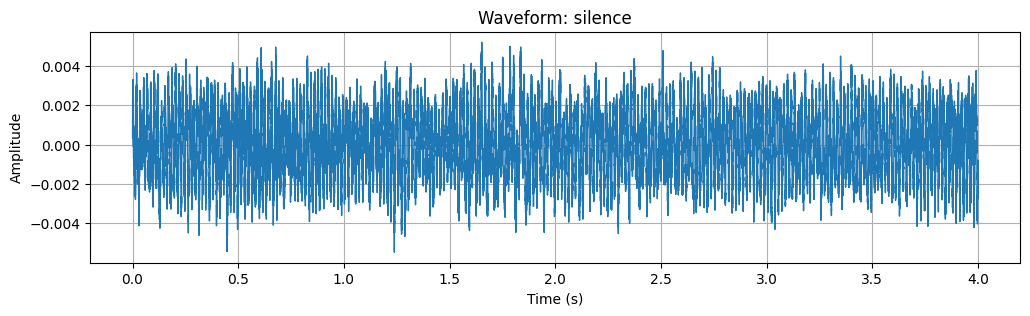

Saved & registered -> EE519_L7_Project\audio\silence.wav


In [9]:
# ========= Recording helper cell =========
# Use this cell multiple times to record different speech tokens.

clip_name = "silence"   # change each time you record
tags = ["silence",]
# notes = "Sustained 'aaaa' at soft loudness with silence before/after"
# notes = "I am taking a speech AI course, spoken fast"
# notes = "shhhh"
# notes = "pa pa pa pa"
notes = "silence with background noise"


seconds = 4.0
fs_rec = 16000

if SOUNDDEVICE_OK:
    fs, y = record_audio(seconds=seconds, fs=fs_rec)
    play_audio(y, fs, label=f"Recorded: {clip_name}")
    plot_waveform(y, fs, title=f"Waveform: {clip_name}")

    out_path = AUDIO_DIR / f"{clip_name}.wav"
    save_wav(out_path, fs, y)
    register_clip(clip_name, out_path, fs, len(y)/fs, tags=tags, notes=notes)
    print("Saved & registered ->", out_path)
else:
    print("sounddevice not available. Use B2: load WAV files instead.")


Recording 4.0s at 16000 Hz... (speak now)
Done. RMS: 0.00844652485102415
Recorded: sentence_normal


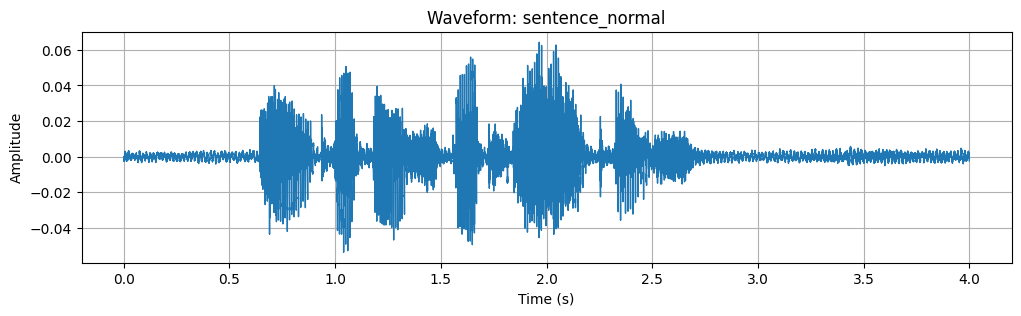

Saved & registered -> EE519_L7_Project\audio\sentence_normal.wav


In [11]:
# ========= Recording helper cell =========
# Use this cell multiple times to record different speech tokens.

clip_name = "sentence_normal"   # change each time you record
tags = ["voiced", "sentence", "normal"]
notes = "Using a sentence to see all changes."

seconds = 4.0
fs_rec = 16000

if SOUNDDEVICE_OK:
    fs, y = record_audio(seconds=seconds, fs=fs_rec)
    play_audio(y, fs, label=f"Recorded: {clip_name}")
    plot_waveform(y, fs, title=f"Waveform: {clip_name}")

    out_path = AUDIO_DIR / f"{clip_name}.wav"
    save_wav(out_path, fs, y)
    register_clip(clip_name, out_path, fs, len(y)/fs, tags=tags, notes=notes)
    print("Saved & registered ->", out_path)
else:
    print("sounddevice not available. Use B2: load WAV files instead.")


### B2) Register external WAV files
If you recorded using another device or you have existing WAVs, place them in the `EE519_L7_Project/audio/` folder and register them here.


In [4]:
# Put WAV files in EE519_L7_Project/audio/ and register them here.
# Example: AUDIO_DIR / "myfile.wav"

wav_to_register = ""  # e.g., str(AUDIO_DIR / "speech_fast.wav")
clip_name = "sentence_fast"
tags = ["sentence", "fast"]
notes = "Same sentence, fast speaking rate"

if wav_to_register and os.path.exists(wav_to_register):
    fs, y = load_wav(wav_to_register)
    play_audio(y, fs, label=f"Loaded: {wav_to_register}")
    out_path = AUDIO_DIR / f"{clip_name}.wav"
    save_wav(out_path, fs, y)  # normalize format
    register_clip(clip_name, out_path, fs, len(y)/fs, tags=tags, notes=notes)
    print("Registered ->", out_path)
else:
    print("No file provided (or not found). Skipping.")


No file provided (or not found). Skipping.


### B3) List your registered clips
Run this anytime to see what you have recorded so far.


#### ✅ Checkpoint: choose clips you can explain
Pick clips where you can point to regions like:
- steady **vowel** (voiced)  
- sustained **/s/** (unvoiced)  
- **stop burst** (brief)  
- **silence/closure** (low energy)

**In-class goal:** you should be able to say “this region is voiced/unvoiced/stop/silence” *before* plotting.


In [12]:
list_clips()


[0] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[1] sentence_normal | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'normal'] | file=EE519_L7_Project/audio/sentence_normal.wav
[2] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project\audio\vowel_a_normal.wav
[3] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[4] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[5] sentence_slow | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'slow'] | file=EE519_L7_Project\audio\sentence_slow.wav
[6] sentence_fast | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'fast'] | file=EE519_L7_Project\audio\sentence_fast.wav
[7] fricative | 4.00s | fs=16000 | tags=['unvoiced', 'fricative'] | file=EE519_L7_Project\audio\fricative.wav
[8] stop | 4.00s | fs=16000 | t

### Quick check ✅
Make sure you have at least:
- 1 voiced vowel
- 1 unvoiced fricative
- 1 stop/burst clip
- 1 sentence (preferably fast + slow)

If not, go back and record/register them now.


---
## C) A controlled nonstationary signal (sinusoid → chirp → harmonics → silence)
We will use this to illustrate why global FFT is insufficient.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Composite signal


Saved figure -> EE519_L7_Project\figures\L7_0_composite_waveform.png


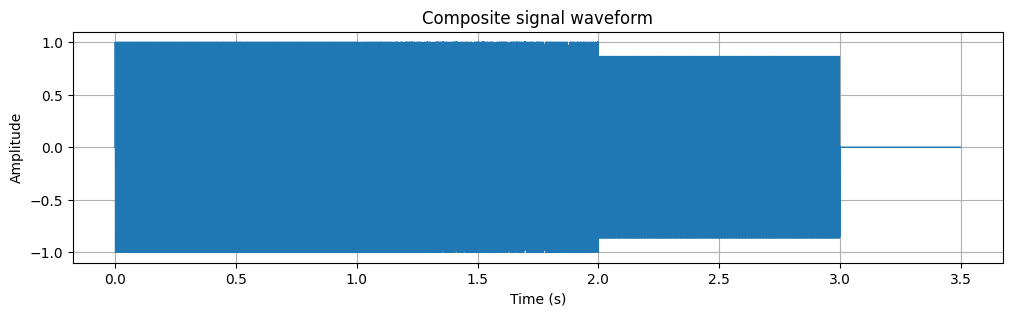

Segments (seconds):
   sinusoid_440 : (0.0, 1.0)
   chirp_200_to_2000 : (1.0, 2.0)
   harmonics_440 : (2.0, 3.0)
   silence : (3.0, 3.5)


In [13]:
fs = 16000
t = np.linspace(0, 1, fs, endpoint=False)

# Segment definitions (we will re-use these time ranges later)
segments = {
    "sinusoid_440": (0.0, 1.0),
    "chirp_200_to_2000": (1.0, 2.0),
    "harmonics_440": (2.0, 3.0),
    "silence": (3.0, 3.5)
}

s1 = np.sin(2*np.pi*440*t)
s2 = chirp(t, f0=200, f1=2000, t1=1.0, method="linear")
s3 = 0.60*np.sin(2*np.pi*440*t) + 0.30*np.sin(2*np.pi*880*t) + 0.20*np.sin(2*np.pi*1320*t)
s4 = np.zeros(int(0.5*fs))

x = np.concatenate([s1, s2, s3, s4]).astype(np.float32)
play_audio(x, fs, label="Composite signal")
plot_waveform(x, fs, title="Composite signal waveform", save_as="L7_0_composite_waveform.png")

print("Segments (seconds):")
for k,v in segments.items():
    print("  ", k, ":", v)


## C1) Global FFT of the entire composite signal
**Prediction:** Will this tell you *when* the chirp happened?


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved figure -> EE519_L7_Project\figures\L7_0_composite_globalFFT.png


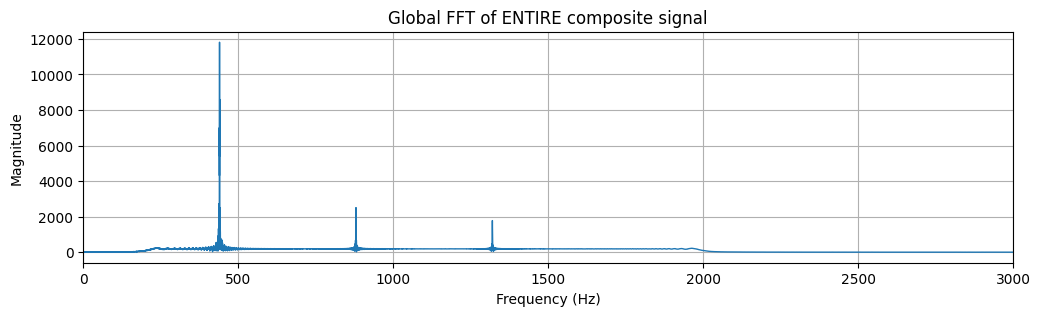

In [14]:
plot_spectrum(x, fs, title="Global FFT of ENTIRE composite signal", fmax=3000, db=False, save_as="L7_0_composite_globalFFT.png")


### What to notice ✅
- You see frequency content, but not time ordering.
- Chirp energy spreads across frequencies, but you don’t know where it occurs in time.


---
## D) Chunk-wise FFT with selectable chunks (NOT sequential-only)
Instead of automatically plotting the first few chunks, we will let you specify **which chunks** (or **which time ranges**) to analyze.

This is closer to how you actually inspect speech: you pick a vowel region, a fricative region, a burst region, etc.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved figure -> EE519_L7_Project\figures\L7_0_composite_chunkFFT.png


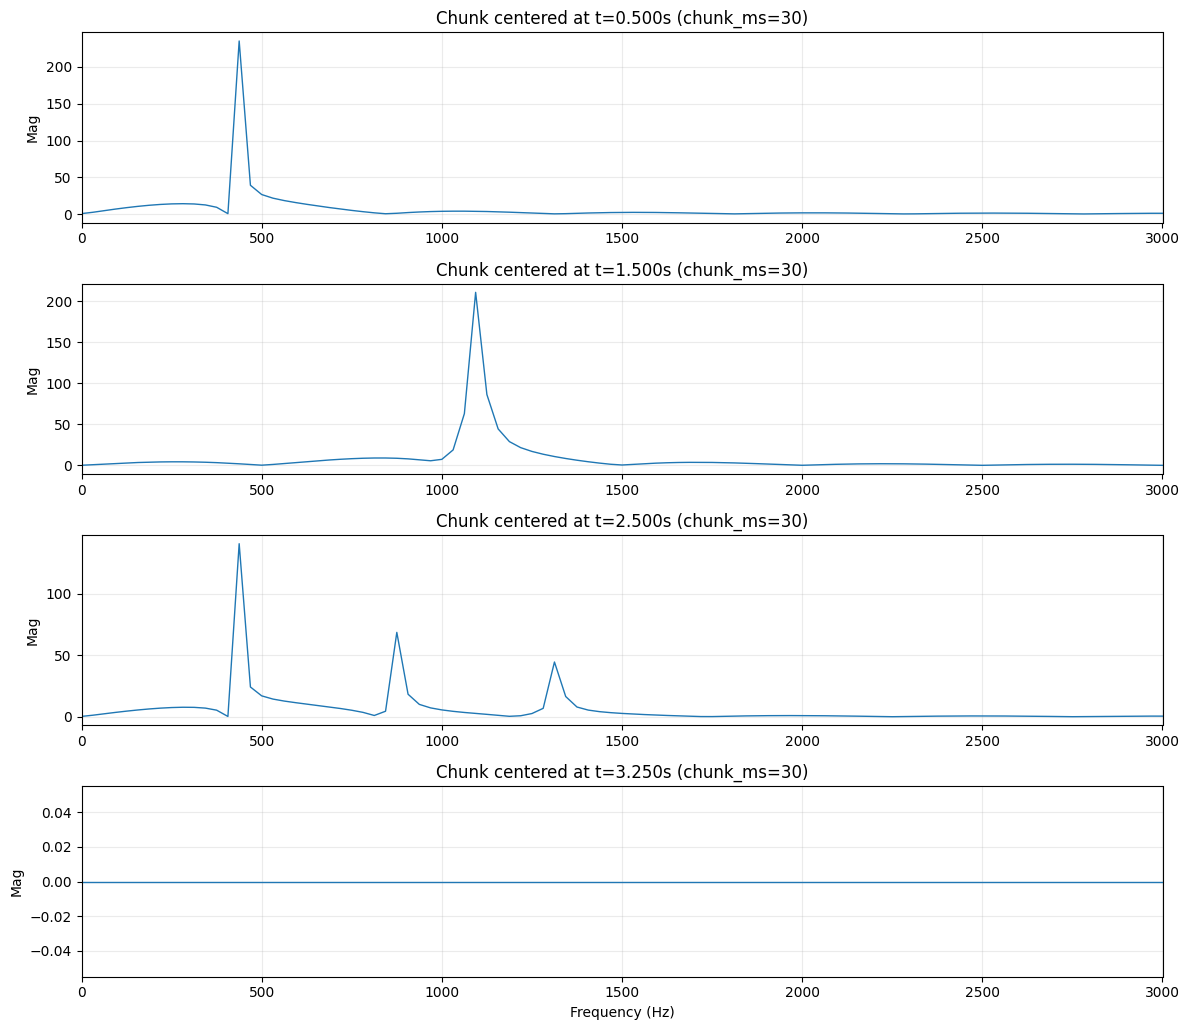

In [19]:
def chunk_fft_at_times(x, fs, chunk_ms=250, centers_s=None, fmax=3000, db=True, save_prefix=None):
    """Compute chunk FFTs centered at given times (in seconds)."""
    if centers_s is None:
        centers_s = [0.5, 1.5, 2.5, 3.25]  # defaults: sinusoid, chirp, harmonics, silence
    L = int(round(chunk_ms * 1e-3 * fs))
    half = L//2

    plt.figure(figsize=(12, 2.6*len(centers_s)))
    for i, c_s in enumerate(centers_s):
        center = int(round(c_s*fs))
        s = max(0, center-half)
        e = min(len(x), s+L)
        seg = x[s:e]
        f, mag = mag_spectrum(seg, fs, nfft=None, db=db)

        plt.subplot(len(centers_s), 1, i+1)
        plt.plot(f, mag, linewidth=1)
        plt.xlim(0, fmax)
        plt.ylabel("dB" if db else "Mag")
        plt.title(f"Chunk centered at t={c_s:.3f}s (chunk_ms={chunk_ms})")
        plt.grid(True, alpha=0.25)

    plt.xlabel("Frequency (Hz)")
    plt.tight_layout()
    if save_prefix is not None:
        out = FIG_DIR / f"{save_prefix}_chunkFFT.png"
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

# Default: choose centers inside each segment
centers = [0.5, 1.5, 2.5, 3.25]
chunk_fft_at_times(x, fs, chunk_ms=30, centers_s=centers, fmax=3000, db=False, save_prefix="L7_0_composite")


### Quick check ✅
Confirm that the selected chunks behave as expected:
- chunk near 0.5s → single peak at 440 Hz
- chunk near 1.5s → broad/changing frequency energy
- chunk near 2.5s → harmonic peaks (440, 880, 1320...)
- chunk near 3.25s → near silence


---
## E) Apply the same inspection idea to your own speech
Here’s the workflow you’ll use throughout Lecture 7:
1. Pick a clip from your manifest
2. Plot waveform
3. Choose 2–5 time points (voiced, unvoiced, silence, burst)
4. Compare spectra
5. Save plots (optional)

### E1) Choose a clip by index
Run `list_clips()` above, then set `clip_index` here.


#### ✅ Checkpoint: choose clips you can explain
Pick clips where you can point to regions like:
- steady **vowel** (voiced)  
- sustained **/s/** (unvoiced)  
- **stop burst** (brief)  
- **silence/closure** (low energy)

**In-class goal:** you should be able to say “this region is voiced/unvoiced/stop/silence” *before* plotting.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


[0] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[1] sentence_normal | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'normal'] | file=EE519_L7_Project/audio/sentence_normal.wav
[2] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project\audio\vowel_a_normal.wav
[3] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[4] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[5] sentence_slow | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'slow'] | file=EE519_L7_Project\audio\sentence_slow.wav
[6] sentence_fast | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'fast'] | file=EE519_L7_Project\audio\sentence_fast.wav
[7] fricative | 4.00s | fs=16000 | tags=['unvoiced', 'fricative'] | file=EE519_L7_Project\audio\fricative.wav
[8] stop | 4.00s | fs=16000 | t

Saved figure -> EE519_L7_Project\figures\L7_0_vowel_a_normal_waveform.png


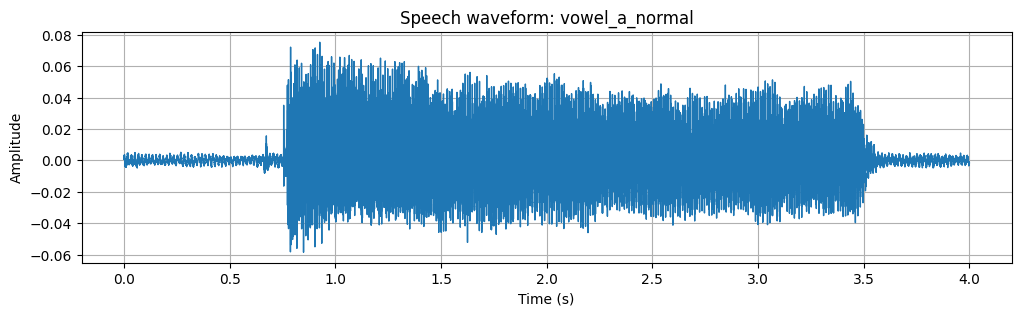

In [17]:
# Pick one clip (by index) from the manifest:
list_clips()
clip_index = 0  # change to a valid index

m = load_manifest()
if len(m["audio_clips"]) > clip_index:
    c = m["audio_clips"][clip_index]
    fs_s, y_s = load_wav(c["path"])
    print("Using clip:", c["name"], "| tags:", c["tags"])
    play_audio(y_s, fs_s, label=c["name"])
    plot_waveform(y_s, fs_s, title=f"Speech waveform: {c['name']}", save_as=f"L7_0_{c['name']}_waveform.png")
else:
    print("No such clip index. Record/register clips first.")


### E2) Choose analysis times (seconds)
Look at your waveform and pick time points.

Suggested strategy:
- For vowels: pick a stable middle region.
- For fricatives: pick a noisy region.
- For stop bursts: pick just after the burst onset.
- Include one silence region for comparison.


Saved figure -> EE519_L7_Project\figures\L7_0_vowel_a_normal_chunkFFT.png


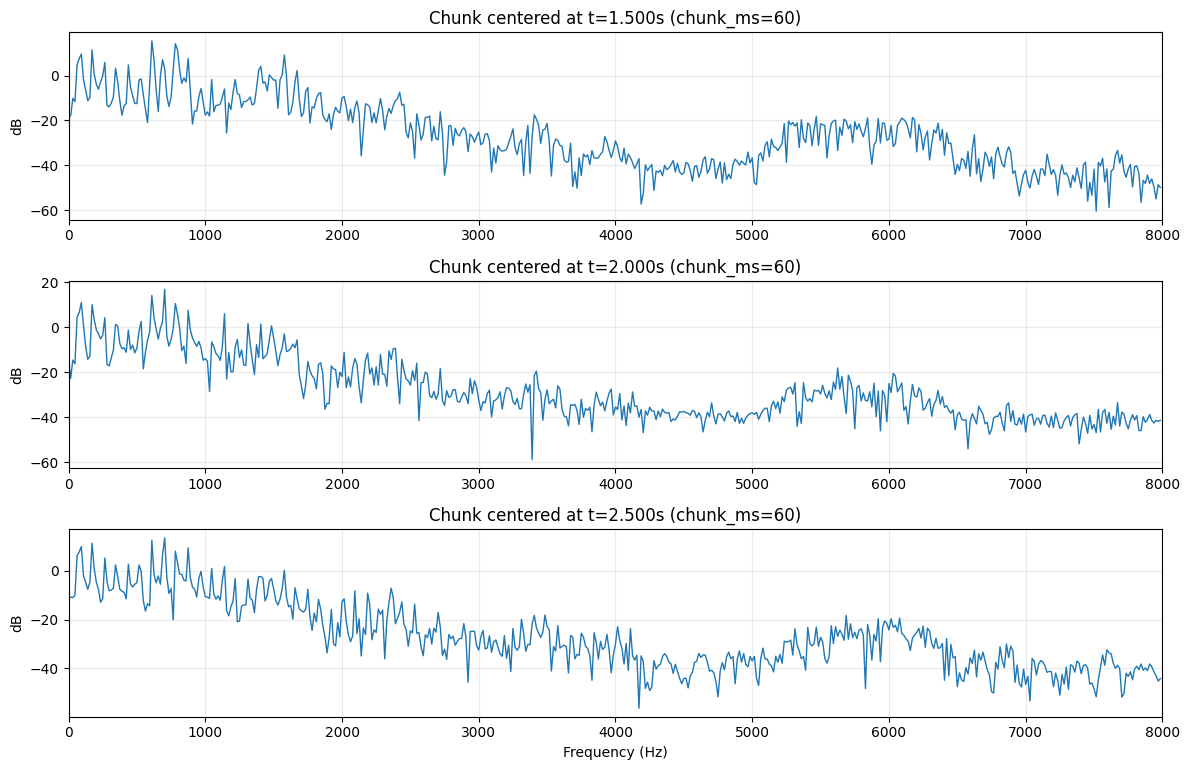

In [18]:
if "y_s" in globals():
    centers_s = [1.5, 2.0, 2.5]  # TODO: edit based on your waveform
    chunk_fft_at_times(y_s, fs_s, chunk_ms=60, centers_s=centers_s, fmax=min(8000, fs_s/2), db=True,
                       save_prefix=f"L7_0_{c['name']}")
else:
    print("No speech clip loaded in this run.")


---
## Reflection + what you learned (write in sentences)

**Answer in this notebook:**
1) Why does a global FFT fail for speech?  
2) What did you observe for voiced vs unvoiced spectra?  
3) What chunk length felt most informative for speech (and why)?  
4) What will STFT add beyond chunk FFT?  

### What’s next
Notebook 7.1: Windowing and leakage (why tapering matters).


### Answers

1. Global FFT assumes the frequency doesn't change but this isn't realistic for speech.
2. Voiced speech shows harmonics but unvoiced doesn't.
3. 20-30 ms
4. SFFT can gives us a spectrogram with shows frequencies over the duration of the audio clip.

---
## ✅ End-of-notebook wrap-up
**Reflection (write in sentences):**
- What parameter change produced the *biggest visible difference* today?
- Which plot helped you most: waveform, spectrum, etc — and why?
- Name one mistake you made (or could make) and how you would debug it.

- Which types of signals (vowels at different loudness levels—soft vs. loud; a short sentence spoken slowly and quickly; sustained fricatives such as /s/ or /ʃ/; and repeated stop consonants such as /pa pa pa/ or /ta ta ta/) reflect which speech properties, and why?


**What’s next:** will proceed to the next Lecture notebook and reuse the same saved recordings.


### Answers

- The window size produced the biggest visible difference.
- The waveform helped me determine chunks but the spectrum helped me understand the concepts better. The consistency across the chunks for the vowel was helpful.
- I could have trouble selecting the right parts of the audio so I would play the audios again and check that I'm loading them correctly.
- The loud vowels had higher amplitude than the soft vowels. The fricatives demonstrated higher frequencies and don't have harmonics. Repeated consonants will show energy bursts compared to constant signals.